In [39]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

In [3]:
feature_set = [
    "GPN-MSA_absLLR",
    "GPN-MSA_InnerProducts",
]

In [5]:
V_train = load_dataset("gonzalobenegas/gwas", split="test").to_pandas()
all_features = []
for features in feature_set:
    df = pd.read_parquet(f"https://huggingface.co/datasets/gonzalobenegas/gwas/resolve/main/features/{features}.parquet")
    df.columns = [f"{features}_{col}" for col in df.columns]
    all_features += df.columns.tolist()
    V_train = pd.concat([V_train, df], axis=1)
V_train

,chrom,pos,ref,alt,pip,maf,trait,label,consequence,tss_dist,...,GPN-MSA_InnerProducts_embedding_758,GPN-MSA_InnerProducts_embedding_759,GPN-MSA_InnerProducts_embedding_760,GPN-MSA_InnerProducts_embedding_761,GPN-MSA_InnerProducts_embedding_762,GPN-MSA_InnerProducts_embedding_763,GPN-MSA_InnerProducts_embedding_764,GPN-MSA_InnerProducts_embedding_765,GPN-MSA_InnerProducts_embedding_766,GPN-MSA_InnerProducts_embedding_767
0,1,930312,C,G,0.001963,0.000683,,False,missense_variant,0,...,68.138504,99.213051,95.974281,131.317001,94.627106,128.216766,177.025513,122.596519,105.207672,182.692383
1,1,976215,A,G,0.005418,0.199367,,False,missense_variant,2703,...,82.939461,117.970123,73.764999,93.852310,75.747147,104.978088,277.127380,91.906082,92.624702,139.742615
2,1,1203822,T,C,0.006379,0.059558,,False,synonymous_variant,1856,...,121.241028,147.089081,68.746323,74.056541,57.824089,74.522461,198.318604,116.197540,56.738262,144.025848
3,1,1224844,C,T,0.001119,0.096291,,False,intron_variant,3750,...,168.910172,346.265656,45.483753,140.871170,109.458862,111.375824,190.793564,192.681671,260.498047,62.282593
4,1,1291417,C,G,0.003143,0.003690,,False,missense_variant,4308,...,95.996613,161.191574,94.903030,107.800102,53.725426,79.316833,139.989944,132.233337,42.795113,166.800537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4589,22,50190508,G,A,1.000000,0.073316,Plt,True,intron_variant,88,...,95.924118,196.216095,71.016647,86.233978,28.755674,66.285851,103.441513,136.004608,25.243877,160.444504
4590,22,50309599,G,A,0.002612,0.005661,,False,3_prime_UTR_variant,1953,...,125.333420,271.003326,76.838684,159.378586,38.740574,71.605637,62.318420,142.769073,31.531269,145.341797
4591,22,50395752,A,G,0.001928,0.083293,,False,intron_variant,23680,...,88.089043,296.317505,40.903725,155.395401,76.366684,242.831558,93.077850,187.598373,126.053909,64.356201
4592,22,50516206,G,A,0.978163,0.095820,MCH,True,intron_variant,6317,...,67.492844,201.446487,76.009674,146.918884,46.383335,58.898941,64.768372,214.938629,49.899147,146.065582


In [7]:
V_test = load_dataset("../../results/gwas/intermediate", split="test").to_pandas()
for features in feature_set:
    df = pd.read_parquet(f"../../results/features/results/gwas/intermediate/{features}.parquet")
    df.columns = [f"{features}_{col}" for col in df.columns]
    V_test = pd.concat([V_test, df], axis=1)
V_test

,chrom,pos,ref,alt,pip,GPN-MSA_absLLR_score,GPN-MSA_InnerProducts_embedding_0,GPN-MSA_InnerProducts_embedding_1,GPN-MSA_InnerProducts_embedding_2,GPN-MSA_InnerProducts_embedding_3,...,GPN-MSA_InnerProducts_embedding_758,GPN-MSA_InnerProducts_embedding_759,GPN-MSA_InnerProducts_embedding_760,GPN-MSA_InnerProducts_embedding_761,GPN-MSA_InnerProducts_embedding_762,GPN-MSA_InnerProducts_embedding_763,GPN-MSA_InnerProducts_embedding_764,GPN-MSA_InnerProducts_embedding_765,GPN-MSA_InnerProducts_embedding_766,GPN-MSA_InnerProducts_embedding_767
0,1,865590,G,C,0.040891,1.977539,85.934868,122.095047,329.237610,312.878479,...,105.563400,198.507278,56.270550,126.963425,50.379749,60.127434,63.993279,215.151794,54.293335,119.140785
1,1,889018,A,C,0.021011,1.642578,285.013885,250.983582,284.679932,516.616211,...,109.327835,562.314575,48.230980,211.522324,91.146149,115.658401,236.735962,260.975464,221.473969,64.742325
2,1,892786,A,G,0.025956,0.592285,118.559143,349.711273,291.639832,440.400085,...,68.115845,664.362305,49.255470,268.181702,88.469727,98.786285,326.277954,342.537109,138.919418,62.225548
3,1,893503,G,A,0.036014,1.341797,330.687775,220.657806,308.718903,539.026611,...,128.698456,500.179688,49.354393,206.581039,89.600677,113.300812,202.064301,265.975006,250.808563,65.863594
4,1,899373,G,C,0.016805,0.961426,326.343506,151.460434,323.004700,526.468994,...,144.426529,434.247528,54.813210,148.048492,82.788017,113.020264,166.809372,193.101059,226.026672,59.557663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365431,9,138124970,C,T,0.047641,1.879883,386.582764,154.020325,298.071411,516.015503,...,132.050674,444.707825,45.495636,217.025238,87.195312,114.858330,139.660355,259.828735,224.601288,57.525795
365432,9,138125513,G,A,0.011438,0.889648,359.400970,200.054672,328.929382,539.151367,...,124.030899,463.582642,54.197315,243.625320,91.585068,124.154991,184.229446,262.971924,272.328857,78.082298
365433,9,138126181,T,A,0.010965,0.676758,178.069336,394.740906,651.386047,757.852661,...,195.413864,214.906082,44.835487,108.708694,123.647446,160.449341,125.583527,141.885864,187.916809,57.663818
365434,9,138154060,A,C,0.014472,0.071777,128.446945,302.502686,387.024933,331.759583,...,65.842712,566.268127,39.002747,279.397552,79.536812,85.388603,178.227005,339.028503,91.365753,76.393456


In [10]:
clf = Pipeline([
    ('scaler', RobustScaler()),
    ('linear', LogisticRegressionCV(
        scoring="roc_auc",
        Cs=np.logspace(-10, 0, 11),
        random_state=42,
        n_jobs=-1,
    ))
])
clf.fit(V_train[all_features], V_train.label)

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

Pipeline(steps=[('scaler', RobustScaler()),
                ('linear',
                 LogisticRegressionCV(Cs=array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00]),
                                      n_jobs=-1, random_state=42,
                                      scoring='roc_auc'))])

In [12]:
clf.named_steps["linear"].C_

array([0.01])

In [13]:
for V in [V_train, V_test]:
    V["score"] = clf.predict_proba(V[all_features])[:, 1]

In [21]:
pearsonr(V_test.pip, V_test.score)

PearsonRResult(statistic=0.09105855893399459, pvalue=0.0)

In [22]:
spearmanr(V_test.pip, V_test.score)

SignificanceResult(statistic=0.08335514526885629, pvalue=0.0)

In [32]:
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [33]:
V_test["score_bin"] = pd.cut(V_test.score, np.linspace(0, 1, 11)).apply(lambda x: x.mid)
V_test["score_bin"].value_counts()

score_bin
0.35                   120653
0.45                    98446
0.25                    55768
0.55                    53492
0.6499999999999999      16954
0.75                     8496
0.8500000000000001       5281
0.15000000000000002      4194
0.95                     1861
0.05                      291
Name: count, dtype: int64

In [35]:
df = V_test.groupby("score_bin").pip.mean().reset_index().rename(columns={"pip": "mean_pip"})
df

,score_bin,mean_pip
0,0.05,0.040387
1,0.15,0.042251
2,0.25,0.040482
3,0.35,0.042424
4,0.45,0.046937
5,0.55,0.052797
6,0.65,0.059888
7,0.75,0.065520
8,0.85,0.077623
9,0.95,0.087913


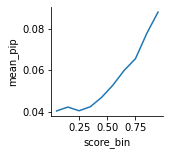

In [40]:
plt.figure(figsize=(2,2))
sns.lineplot(
    data=df,
    x="score_bin",
    y="mean_pip",
)
sns.despine();

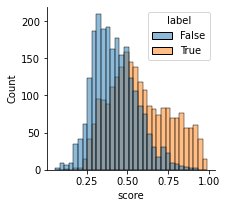

In [43]:
plt.figure(figsize=(3,3))
sns.histplot(
    data=V_train,
    x="score",
    hue="label",
)
sns.despine();

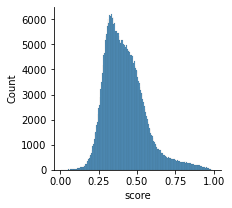

In [44]:
plt.figure(figsize=(3,3))
sns.histplot(
    data=V_test,
    x="score",
)
sns.despine();